<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/CUDA-QX/optimizations/cudaq_graph_coloring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install cudaq-solvers==0.2.1 pyqubo==1.5.0 networkx==3.4.2 -q

# **Solving Grpah Coloring with CUDA-Q Solvers**

The graph coloring problem asks how to assign colors to the vertices of a graph so that no two adjacent vertices share the same color. Each vertex must be assigned exactly one color from a given set, and adjacent (connected) vertices must have different colors to avoid conflict. That is, given:  
- Binary variables $x_{v,c} \in \{0,1\}$, where $x_{v,c} = 1$ if vertex $v$ is assigned color $c$, otherwise 0.  
- $v$ ranges over all vertices.  
- $c$ ranges over all colors.  
- $(u,v)$ are edges connecting vertices.

The objective function $ f(x) $ in **QUBO** (Quadratic Unconstrained Binary Optimization) formulation to be minimized:

$$
f(x) = A \sum_{v} \left( \sum_{c} x_{v,c} - 1 \right)^2 + B \sum_{(u,v) \in \text{edges}} \sum_{c} x_{u,c} \, x_{v,c}
$$

Where:  
- The **first constraint** $ \sum_{v} \left( \sum_{c} x_{v,c} - 1 \right)^2 $ with scaling factor $ A $ ensures that each vertex is assigned exactly one color (i.e., exactly one $x_{v,c} = 1$ for each vertex $v$.).  
- The **second constraint** $ \sum_{(u,v)} \sum_{c} x_{u,c} x_{v,c} $ with scaling factor $ B $ penalizes the scenario where two adjacent vertices $ (u,v) $ are assigned the same color.

In [38]:
from pyqubo import Array, Constraint


# Define graph edges
edges = [(0, 1), (1, 2), (2, 0)]
n_vertices = 3
n_colors = 3

# Binary variables: x[v][c] = 1 if vertex v is colored with c
variables = Array.create('x', shape=(n_vertices, n_colors), vartype='BINARY')

# Constraint-1: Each vertex must have exactly one color
one_color_per_vertex = sum(
    (sum(variables[v][c] for c in range(n_colors)) - 1)**2
    for v in range(n_vertices)
)

# Constraint-2: Adjacent vertices cannot share the same color
no_same_color_edges = sum(
    variables[u][c] * variables[v][c]
    for (u, v) in edges
    for c in range(n_colors)
)

# Combine the constraints to form the objective function
A = 5  # Penalty for violating one-color constraint
B = 4   # Penalty for adjacent same-color
objective = A * Constraint(one_color_per_vertex, label='one_color') + B * Constraint(one_color_per_vertex, label='same_color')

# Compile
model = objective.compile()

Note that the QUBO formulation from PyQUBO is based on the 0 and 1 basis. Here, we aim to transform it into the -1 and 1 basis and construct the Hamiltonian with Ising formulation, making it compatible for use with CUDA-Q:

In [39]:
import cudaq
from cudaq import spin
import numpy as np
from typing import List


def to_cudaq(model):
    """
    Convert a binary optimization model to QAOA inputs compatible with CUDA-Q.

    This function extracts the linear and quadratic coefficients from the model's
    Ising formulation, maps variables to qubit indices, and constructs CUDA-Q Hamiltonian.
    """

    h, J, offset = model.to_ising()

    # Map variables to qubit indices
    vars_set = set(h) | {v for pair in J for v in pair}
    var_to_index = {var: idx for idx, var in enumerate(sorted(vars_set))}

    # Initialization
    H = 0

    # Fill in linear terms (diagonal)
    for var, weight in h.items():
        idx = var_to_index[var]
        H += weight * spin.z(idx)

    # Fill in quadratic terms (off-diagonal)
    for (v1, v2), weight in J.items():
        i, j = var_to_index[v1], var_to_index[v2]
        H += weight * spin.z(i) * spin.z(j)

    H += offset

    return H


H = to_cudaq(model)
print("Hamiltonian:", H)

Hamiltonian: [4.5+0j] IIIZIZIII
[4.5+0j] IIIIIIIZZ
[4.5+0j] IIIIZIIII
[4.5+0j] IIZIIIIII
[4.5+0j] ZIIIIIIII
[4.5+0j] IIIIIIZZI
[4.5+0j] IZIIIIIII
[4.5+0j] IIIIZZIII
[4.5+0j] ZIZIIIIII
[4.5+0j] IIIIIIZIZ
[4.5+0j] IIIIIIIIZ
[4.5+0j] IIIIIIIZI
[27+0j] IIIIIIIII
[4.5+0j] IIIZZIIII
[4.5+0j] IZZIIIIII
[4.5+0j] IIIIIIZII
[4.5+0j] IIIZIIIII
[4.5+0j] IIIIIZIII
[4.5+0j] ZZIIIIIII



##**QAOA using cudaq-solvers.qaoa**
The **Quantum Approximate Optimization Algorithm (QAOA)** is a variational quantum algorithm designed to solve **combinatorial optimization problems  (COPs)**.
CUDA-Q Solvers provides the built-in `cudaq-solvers.qaoa` API, offering a simple and intuitive approach to tackle COPs using QAOA:

In [40]:
import cudaq_solvers as solvers
import numpy as np


# Get the number of parameters we'll need
num_layers = 5
parameter_count = solvers.get_num_qaoa_parameters(H,
                                                  num_layers,
                                                  full_parameterization=True)

# Create the initial parameters to begin optimization
initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)

# Set up the optimizer for convergence; supported cudaq-x optimizers include 'cobyla' and 'lbfgs'
optimizer = 'cobyla'

# Run QAOA, specify full parameterization using an optimization parameter for
# every term in the problem Hamiltonian and the mixer hamiltonian.
opt_value, opt_params, opt_config = solvers.qaoa(H,
                                                 num_layers,
                                                 initial_parameters,
                                                 optimizer=optimizer,
                                                 full_parameterization=True,
                                                 )

# Print the results
print('Optimal energy: ', opt_value)
print('Sampled states: ', opt_config)
print('Optimal Configuration: ', opt_config.most_probable())

Optimal energy:  4.104590349385262e-06
Sampled states:  { 011011011:33 011011101:14 011011110:10 011101011:73 011101101:24 011101110:17 011110011:91 011110101:34 011110110:21 101011011:65 101011101:21 101011110:14 101101011:186 101101101:54 101101110:33 101110011:200 101110101:51 101110110:42 110011011:2 110011101:2 110101011:2 110101101:2 110101110:1 110110011:5 110110101:1 110110110:2 }

Optimal Configuration:  101110011


Note that in **PyQUBO**, the variables (`Binary`) are originally **0 or 1**:  $ x_{u(v),c} \in \{0, 1\} $

Meanwhile, in the **Ising form**, the variables are represented as **-1 or +1**: $ s_{u(v),c} \in \{-1, 1\} $

To convert the sampled bitstring back to the pre-defined variable $x$, we should apply the transformation:
$$
x = \frac{1 - s}{2}
$$

In [41]:
def to_variables(variables, most_probable_bits):
    """
    Convert Ising bitstring string (s ∈ {-1,1}) to predefined Binary variables (x ∈ {0,1})
    for a 2D variable structure.
    """
    result = {}
    idx = 0
    for row in variables:
        for var in row:
            result[str(var)] = int((1 - (1 if most_probable_bits[idx] == '1' else -1)) // 2)
            idx += 1
    return result



# Print result
most_probable_bits = opt_config.most_probable()
best_result = to_variables(variables, most_probable_bits)
print("Best result:", best_result)

Best result: {"Binary('x[0][0]')": 0, "Binary('x[0][1]')": 1, "Binary('x[0][2]')": 0, "Binary('x[1][0]')": 0, "Binary('x[1][1]')": 0, "Binary('x[1][2]')": 1, "Binary('x[2][0]')": 1, "Binary('x[2][1]')": 0, "Binary('x[2][2]')": 0}


Let's visualize the graph coloring result using `networkx` to check whether the assigned colors satisfy the constraints:

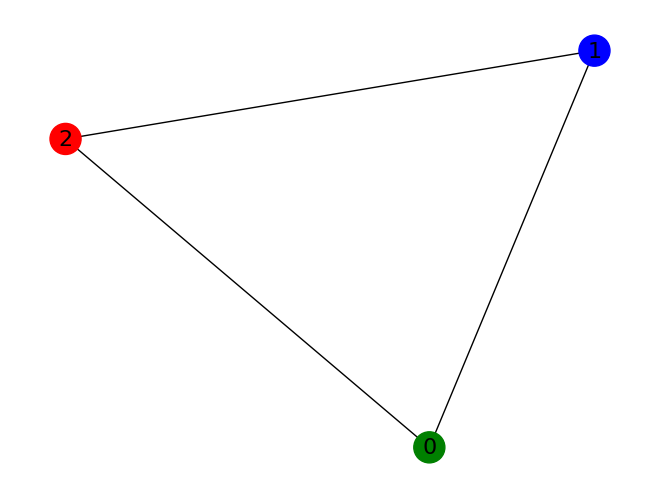

In [42]:
import networkx as nx
import matplotlib.pyplot as plt


# Color map for visualizing the colors assigned to vertices
color_map = {0: 'red', 1: 'green', 2: 'blue'}

# Create the graph
G = nx.Graph()
G.add_edges_from(edges)

# Assign colors to vertices based on the result
node_colors = []
for node in range(n_vertices):
    for color in range(n_colors):
        if best_result.get(f"Binary('x[{node}][{color}]')") == 1:
            node_colors.append(color_map[color])

# Draw the graph with assigned colors
nx.draw(G, with_labels=True, node_color=node_colors[:n_vertices], node_size=500, font_size=16)
plt.show()

##**Comparison with Simulated Annealing solver from `neal`**

In [43]:
import neal


# Convert the pre-defined model to QUBO
qubo, offset = model.to_qubo()

# Solve with simulated annealing
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo, num_reads=100)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset)
best = min(decoded_samples, key=lambda s: s.energy)

# Print result
print("Best result:", best.sample)
print("Energy (including offset):", best.energy)

Best result: {'x[2][2]': 1, 'x[2][1]': 0, 'x[1][2]': 1, 'x[1][1]': 0, 'x[2][0]': 0, 'x[0][2]': 1, 'x[1][0]': 0, 'x[0][1]': 0, 'x[0][0]': 0}
Energy (including offset): 0.0
